In [24]:
#Import basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Import feature selection library
from mrmr import mrmr_classif
from sklearn.feature_selection import mutual_info_classif

In [2]:
#Open all datasets

df_final = pd.read_csv('final_data_cleaned_7apr_heatmap_dropped_hotkey.csv', index_col = [0])
df_demo = pd.read_csv('demographic.csv', index_col = [0])
df_physical_og = pd.read_csv('physical_exam_og.csv', index_col = [0])
df_physical_translated = pd.read_csv('physical_exam_translated.csv', index_col = [0])
df_diabetes_stat = pd.read_csv('diabetes_stat_complete.csv', index_col = [0])
df_blood_mineral = pd.read_csv('blood_mineral_og.csv', index_col = [0])
df_blood_mineral_translated = pd.read_csv('blood_mineral_relabeled.csv', index_col = [0])
df_blood_nutrient = pd.read_csv('blood_nutrient_og.csv')

### Below are the updated features:
1. 'Race' --> Changed names to drop 'NHA' suffix
2. 'Pregnancy' --> Change rows that are not defined to 'Unknown'. For all rows with male gender, then put 'Not Applicable'
3. 'large_family' --> If People HH > 3 then 1; 0 otherwise
4. 'MaritalStatus' --> updated to 'Married', 'Single', 'Separated/Divorced', 'Unknown'
5. 'USStayLength' --> updated to 'Unknown', 'Short Term (if less <= 10 years)', 'Long Term (>10 years)'
6. 'FamilyIncome' --> updated to 'Low' (if <= 55k), 'Medium' (between 55k to 100k), 'High'(>100k) based on US baseline
7. 'college_educated' --> 1 if college educated, 0 if not college educated, 2 if unknown
8. 'Citizenship' --> 0 if not US citizen, 1 if US citizen
9. 'high_risk' (diabetic potential) --> 1 if BMI is above or equal to 25, Two Hour Glucose(OGTT) (mg/dL) >= 140 and 'Glycohemoglobin (%)' >= 5.7; 0 otherwise
10. 'Any Dietary Supplements Taken?' --> Set categorical to 1 and 0
11. 'Dental Implants? Yes/No' --> Set categorical to 1 and 0
12. 'Overall Oral Health Exam Status' --> Set categorical to 1 and 0

Note that 'PeopleHH' and 'EduLevelAdult' are dropped after getting replaced by 1. and 5.

In [3]:
#Clean demographic data
og_race = ['NHA-NHBlack', 'NHA-NHWhite', 'NHA-MexAmerican', 'NHA-OtherHisp', 'Other', 'NHA-NHAsian']
cleaned_race = ['Black', 'White', 'Mexican American', 'Other Hispanic', 'Other', 'Asian']

count = 0
for race in og_race:
    df_demo.iloc[df_demo['RaceNHA'] == race, 3] = cleaned_race[count]
    count += 1
    
## Replace Unknown Variables

df_demo.iloc[(df_demo['Gender'] == 'Female') & (~df_demo['PregnancyStatus'].isin(['CannotTell', 'Unknown', 'NotPregnant','Pregnant'])), 9] = 'Unknown'
df_demo.iloc[df_demo['Gender'] == 'Male', 9] = 'NotApplicable'

df_demo.iloc[(~df_demo['Citizenship'].isin(['USCitizen','NonUSCitizen', 'Refused','DontKnow'])), 5] = 'Unknown'
df_demo.iloc[(~df_demo['USStayLength'].isin(['10-15','20-30','5-10','30-40','1-5','>50','40-50','15-20','DontKnow','Refused','<1'])), 6] = 'Unknown'
df_demo.iloc[(~df_demo['EduLevelAdult'].isin(['HighSchool/GED','College/AA','3Grade','College/Above', '9-11Grade', '2Grade' ,'4Grade', '9Grade', '>9Grade' ,'>HighSchool' ,'6Grade', '1Grade', '7Grade', '8Grade' ,'NoEdu/KG', '5Grade', '10Grade' ,'11Grade', 'HighSchool'
, '12Grade', 'GED' ,'>5Grade', 'DontKnow', 'Refused'])), 7] = 'Unknown'
df_demo.iloc[(~df_demo['MaritalStatus'].isin(['Separated', 'Married' , 'Divorced' ,'Widowed', 'NeverMarried' ,'LivingIn'
 ,'Refused', 'DontKnow'])), 8] = 'Unknown'

df_demo = df_demo.merge(df_diabetes_stat, on='SEQN', how='inner')

In [4]:
df_final = pd.read_csv('merged_raw.csv', index_col = [0])
df_final.dropna(inplace=True)

In [5]:
#Drop all irrelevant columns from merged_raw

col_to_drop = ['Amount of glucose challenge drank',
'Total length of "food fast," hours',
'Total # of Antacids Taken',
'Any Antacids Taken?',
'Blood Pressure Status',
'Recumbent Length (cm)',
'Head Circumference (cm)',
'Weight (kg)',
'Sagittal Abdominal Diameter 1st (cm)',
'Grip strength (kg), hand 1, test 1',
'Grip strength (kg), hand 2, test 1',
'Dominant hand', 
'Testing position',
'Grip strength (kg), hand 1, test 1',
'Grip strength (kg), hand 2, test 1',
'Salmon eaten during past 30 days',
'Coronal Caries: Surface condition #2',
'Dental Sealants: Upper right 2nd molar (2M) sealant codes',
'Coronal Caries: Tooth count #2',
'Is_Diabetic', 
'final_IsDia',
'Unnamed: 0.1',
'BirthCountry']

df_final.drop(columns=col_to_drop, inplace = True)

In [6]:
# Clean PeopleHH
df_final.loc[df_final['PeopleHH'] > 3 , 'large_family'] = 1
df_final.loc[df_final['PeopleHH'] <= 3 , 'large_family'] = 0

In [7]:
# Clean EduLevelAdult
df_final.loc[~df_final['EduLevelAdult'].isin(['College/AA', 'College/Above', '>HighSchool']) , 'college_educated'] = 0
df_final.loc[df_final['EduLevelAdult'].isin(['College/AA', 'College/Above', '>HighSchool']) , 'college_educated'] = 1
df_final.loc[df_final['EduLevelAdult'].isin(['Unknown', 'DontKnow']) , 'college_educated'] = 2

In [8]:
# Clean FamilyIncome
df_final.loc[df_final['FamilyIncome'].isin(['<5k','5-10k', '10-15k','15-20k', '20-25k', '25-35k','35-45k', '45-55k']) , 'FamilyIncome'] = 'Low'
df_final.loc[df_final['FamilyIncome'].isin(['55-65k','65-75k', '75-99k']) , 'FamilyIncome'] = 'Medium'
df_final.loc[df_final['FamilyIncome'].isin(['>100k']) , 'FamilyIncome'] = 'High'

In [9]:
# Clean USStayLength
df_final.loc[df_final['USStayLength'].isin(['Unknown','DontKnow', 'Refused']) , 'USStayLength'] = 'Unknown'
df_final.loc[df_final['USStayLength'].isin(['<1', '1-5', '5-10']) , 'USStayLength'] = 'Short Term (< 10 Years)'
df_final.loc[df_final['USStayLength'].isin(['10-15', '15-20','20-30', '30-40','40-50', '>50']) , 'USStayLength'] = 'Long Term (> 10 Years)'

In [10]:
# Clean Citizenship
df_final.loc[df_final['Citizenship'] != 'USCitizen', 'Citizenship'] = 0
df_final.loc[df_final['Citizenship'] == 'USCitizen', 'Citizenship'] = 1

In [11]:
# Drop changed columns
changed_col = ['PeopleHH', 'EduLevelAdult']
df_final.drop(columns=changed_col, inplace = True)

In [12]:
# Clean Marital Status
df_final.loc[df_final['MaritalStatus'].isin(['Unknown','DontKnow', 'Refused']) , 'MaritalStatus'] = 'Unknown'
df_final.loc[df_final['MaritalStatus'].isin(['Divorced', 'Separated', 'Widowed']) , 'MaritalStatus'] = 'Separated/Divorced'
df_final.loc[df_final['MaritalStatus'].isin(['Married', 'LivingIn']) , 'MaritalStatus'] = 'Married'
df_final.loc[df_final['MaritalStatus'].isin(['NeverMarried']) , 'MaritalStatus'] = 'Single'

In [13]:
#Create high risk variables
df_final['high_risk'] = 0
df_final.loc[(df_final['AgeYears'] <= 20) & (df_final['Body Mass Index (kg/m**2)'] >= 25) & (df_final['Glycohemoglobin (%)'] >= 5.7) & (df_final['Two Hour Glucose(OGTT) (mg/dL)'] >= 140), 'high_risk'] = 1
df_final.loc[(df_final['AgeYears'] > 20) & (df_final['AgeYears'] <= 40) & (df_final['Body Mass Index (kg/m**2)'] >= 25) & (df_final['Glycohemoglobin (%)'] >= 5.7) & (df_final['Two Hour Glucose(OGTT) (mg/dL)'] >= 120), 'high_risk'] = 1
df_final.loc[(df_final['AgeYears'] > 40) & (df_final['Body Mass Index (kg/m**2)'] >= 25) & (df_final['Glycohemoglobin (%)'] >= 5.7) & (df_final['Two Hour Glucose(OGTT) (mg/dL)'] >= 100), 'high_risk'] = 1

In [14]:
#Clean categorical values for dietary supplements, dental implant and overall oral health exam status to 0 or 1

df_final.loc[df_final['Any Dietary Supplements Taken?'] == 1, 'Any Dietary Supplements Taken?'] = 0
df_final.loc[df_final['Any Dietary Supplements Taken?'] == 2, 'Any Dietary Supplements Taken?'] = 1
df_final.loc[df_final['Any Dietary Supplements Taken?'] == 1.01, 'Any Dietary Supplements Taken?'] = 1

df_final.loc[df_final['Dental Implant: yes / no?'] == 1.97, 'Dental Implant: yes / no?'] = 2
df_final.loc[df_final['Dental Implant: yes / no?'] == 1, 'Dental Implant: yes / no?'] = 0
df_final.loc[df_final['Dental Implant: yes / no?'] == 2, 'Dental Implant: yes / no?'] = 1
df_final.loc[df_final['Overall Oral Health Exam Status'] == 1.13, 'Overall Oral Health Exam Status'] = 1

In [15]:
#Set is_healthy variable: takes dietary supplements, Systolic less than 120, Diastolic less than 80 and Overall Oral Health Exam Status = 1.

df_final.loc[(df_final['Any Dietary Supplements Taken?'] == 1) & (df_final['Systolic: Blood pressure (first reading) mm Hg'] < 120) & (df_final['Diastolic: Blood pressure (second reading) mm Hg'] < 80) & (df_final['Overall Oral Health Exam Status'] == 1), 'is_healthy'] = 1
df_final.loc[df_final['is_healthy'] != 1, 'is_healthy'] = 0

#Drop Water and Cholestrol columns
df_final.loc[(df_final['LDL-Cholesterol'] < 150) & (df_final['How often add salt to food at table'] < 3) & (df_final['Body Mass Index (kg/m**2)'] < 25) & (df_final['Total fat (gm)'] < 1.50), 'is_cardio_high_risk'] = 0
df_final.loc[df_final['is_cardio_high_risk'] != 0, 'is_cardio_high_risk'] = 1
df_final.drop(columns=['Cholesterol (mg)', 'Total bottled water drank yesterday (gm)'], inplace=True)

#Drop cardio high risk because everything is 1
df_final.drop(columns='is_cardio_high_risk', inplace=True)

In [16]:
#Remove outliers in various columns

dict_threshold = {'Cadmium (ug/L)': 2, 'Lead (ug/dL)' : 3, 'Blood manganese (ug/L)' : 15, 'Mercury, total (ug/L)' : 5,
                  'Segmented neutrophils number' : 15, 'Eosinophils number': 2, 'Energy (kcal)': 50, 'Protein (gm)' : 25, 'Carbohydrate (gm)': 25,
                 'Total sugars (gm)': 15, 'Lycopene (mcg)' : 5000, 'Lutein + zeaxanthin (mcg)' : 5000, 'Thiamin (Vitamin B1) (mg)': 200, 'Niacin (mg)': 200,
                 'Vitamin B6 (mg)': 500, 'Vitamin B12 (mcg)':2000, 'Vitamin C (mg)': 2000, 'Vitamin K (mcg)': 1000, 'Sodium (mg)' : 200, 'Iodine (mcg)': 1200}

for key, value in dict_threshold.items():
    df_final = df_final[df_final[key] < value]

In [17]:
df_final.shape

(8610, 82)

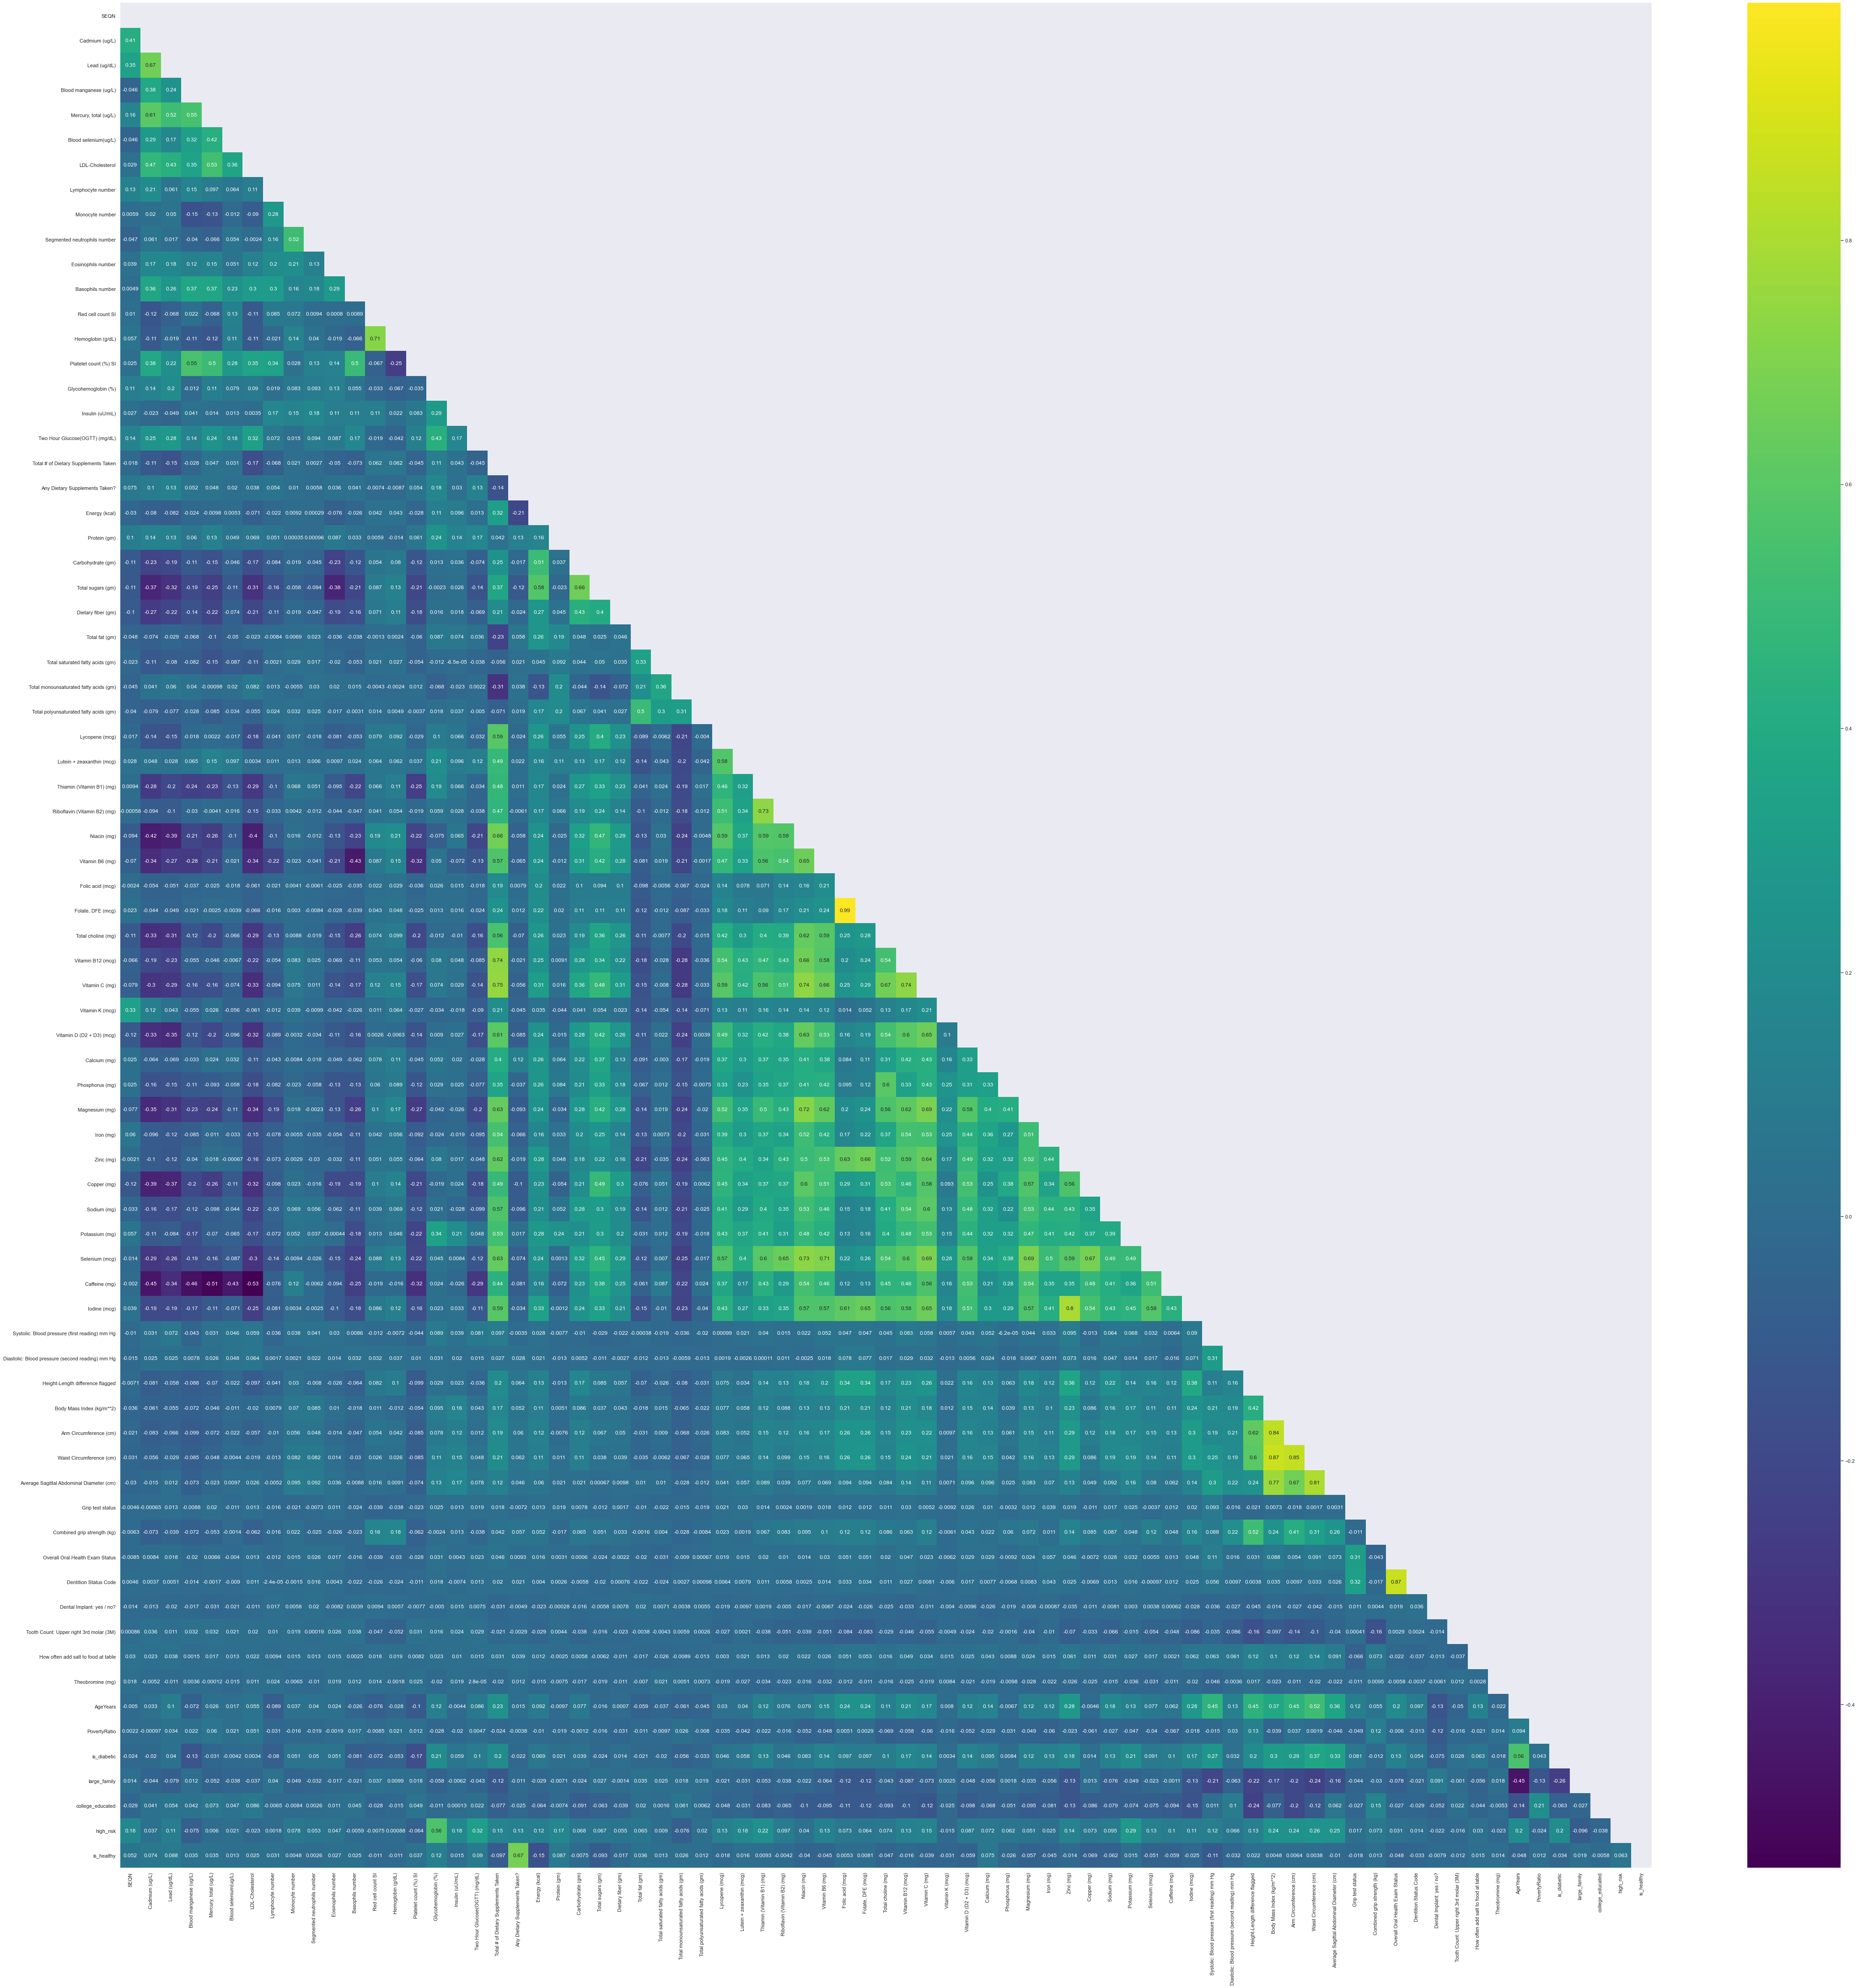

In [18]:
sns.set(rc = {'figure.figsize':(75, 75)})
corr = df_final.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, fmt=".2g", cmap='viridis', mask=matrix)
plt.show()

In [19]:
#Drop variables with high multicorrelationarity

col_to_drop = ['Folic acid (mcg)', 'Arm Circumference (cm)', 'Waist Circumference (cm)', 'Average Sagittal Abdominal Diameter (cm)', 'Iodine (mcg)', 'Dentition Status Code']
df_final.drop(columns=col_to_drop, inplace=True)
df_final.to_csv('final_data_cleaned_7apr_heatmap_dropped.csv', index=False)

In [20]:
#Add hot key encoding

df_hot_encoded = pd.get_dummies(data=df_final, columns=['Gender', 'Race', 'USStayLength', 'MaritalStatus', 'PregnancyStatus', 'FamilyIncome'])
df_hot_encoded.to_csv('final_data_cleaned_7apr_heatmap_dropped_hotkey.csv')

In [21]:
#Define MI and MRMR functions, along with the threshold list

threshold_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]  # the number of most relevant features

def get_mi_features(threshold, X, selected_X_df, selected_y):
    selected_features_dict = {}
    selected_scores_dict = {}
    
    for limit in threshold:
        feature_scores = mutual_info_classif(X, selected_y, random_state= 123)
        selected_features = []
        selected_scores = []
        for score, f_name in sorted(zip(feature_scores, selected_X_df), reverse=True)[:limit]:
            selected_features.append(f_name)
            selected_scores.append(score)
        selected_features_dict[limit] = selected_features
        selected_scores_dict[limit] = selected_scores
        
    return selected_features_dict, selected_scores_dict

def get_mrmr_features(selected_data_X, selected_y, selected_K):
    selected_features = mrmr_classif(selected_data_X, selected_y, selected_K)
    
    return selected_features

In [22]:
#Set X and Y values
y = df_hot_encoded['is_diabetic'].values
X = df_hot_encoded.drop(columns='is_diabetic').values
selected_X_df = df_hot_encoded.drop(columns='is_diabetic')

In [25]:
#Get MI features
mi_features, mi_scores = get_mi_features(threshold_list, X, selected_X_df, y)
mi_features

{10: ['AgeYears',
  'SEQN',
  'MaritalStatus_Unknown',
  'Body Mass Index (kg/m**2)',
  'Combined grip strength (kg)',
  'Platelet count (%) SI',
  'Height-Length difference flagged',
  'Glycohemoglobin (%)',
  'Basophils number',
  'Vitamin C (mg)'],
 20: ['AgeYears',
  'SEQN',
  'MaritalStatus_Unknown',
  'Body Mass Index (kg/m**2)',
  'Combined grip strength (kg)',
  'Platelet count (%) SI',
  'Height-Length difference flagged',
  'Glycohemoglobin (%)',
  'Basophils number',
  'Vitamin C (mg)',
  'Vitamin B12 (mcg)',
  'Vitamin B6 (mg)',
  'Two Hour Glucose(OGTT) (mg/dL)',
  'Folate, DFE (mcg)',
  'Vitamin D (D2 + D3) (mcg)',
  'Lycopene (mcg)',
  'Niacin (mg)',
  'Potassium (mg)',
  'Systolic: Blood pressure (first reading) mm Hg',
  'Cadmium (ug/L)'],
 30: ['AgeYears',
  'SEQN',
  'MaritalStatus_Unknown',
  'Body Mass Index (kg/m**2)',
  'Combined grip strength (kg)',
  'Platelet count (%) SI',
  'Height-Length difference flagged',
  'Glycohemoglobin (%)',
  'Basophils number',
  

In [26]:
#Get MRMR features
mrmr_features_dict = {}

for threshold in threshold_list:
    mrmr_features = get_mrmr_features(selected_X_df, y, threshold)
    mrmr_features_dict[threshold] = mrmr_features

mrmr_features_dict

100%|██████████| 90/90 [00:10<00:00,  8.49it/s]


{10: ['AgeYears',
  'Insulin (uU/mL)',
  'MaritalStatus_Unknown',
  'Platelet count (%) SI',
  'Body Mass Index (kg/m**2)',
  'Systolic: Blood pressure (first reading) mm Hg',
  'Glycohemoglobin (%)',
  'large_family',
  'PregnancyStatus_Unknown',
  'Total # of Dietary Supplements Taken'],
 20: ['AgeYears',
  'Insulin (uU/mL)',
  'MaritalStatus_Unknown',
  'Platelet count (%) SI',
  'Body Mass Index (kg/m**2)',
  'Systolic: Blood pressure (first reading) mm Hg',
  'Glycohemoglobin (%)',
  'large_family',
  'PregnancyStatus_Unknown',
  'Total # of Dietary Supplements Taken',
  'MaritalStatus_Separated/Divorced',
  'Potassium (mg)',
  'MaritalStatus_Married',
  'PregnancyStatus_NotPregnant',
  'high_risk',
  'Overall Oral Health Exam Status',
  'Blood manganese (ug/L)',
  'Height-Length difference flagged',
  'Vitamin B12 (mcg)',
  'Race_White'],
 30: ['AgeYears',
  'Insulin (uU/mL)',
  'MaritalStatus_Unknown',
  'Platelet count (%) SI',
  'Body Mass Index (kg/m**2)',
  'Systolic: Blood 